In [1]:
%matplotlib inline


# Clustering progressive passes
In this tutorial we show how to cluster progressive passes using KMeans clustering. 


In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os
import pathlib
import json
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Opening the dataset

First we open the data. It is exactly the same way as we did in the previous tutorials.



In [3]:
path = '../../data/Wyscout/events/events_England.json'
df = pd.read_json(path)

## Preparing the dataset

Data preprocessing is also done in a similar manner. First we take the *matchId* of the game we want to analyze. Then,
we filter out passes which ended in (0, 68) or (105, 0) as well as ones that ended out of the pitch. Clustering
progressive passes can be also done for on player and the entire season!



In [4]:
#get events from match
match_id = 2500045
#get passes from this match
match_events = df.loc[df["matchId"] == match_id]
next_event = match_events.shift(-1, fill_value=0)
match_events["nextEvent"] = next_event["subEventName"]
match_events["kickedOut"] = match_events.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
passes = match_events.loc[match_events["eventName"] == "Pass"]
#change coords to better find progressive
passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
delete_passes = passes.loc[passes["kickedOut"] == 1]
passes = passes.drop(delete_passes.index)
passes = passes.loc[(((passes["end_x"] != 0) & (passes["end_y"] != 68)) & ((passes["end_x"] != 105) & (passes["end_y"] != 0)))]

## Finding out progressive passes

To cluster progressive passes we need to define them. In this tutorial we will follow Wyscouts definition available
[here](https://dataglossary.wyscout.com/progressive_pass/). Also, we keep only passes made by Manchester United.



In [5]:
def is_progressive(x, y, end_x, end_y):
    start_dist = np.sqrt((105 - x)**2 + (34 - y)**2)
    end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2)
    #mark that passes to own half are not progressive
    thres = 100
    if x < 52.5 and end_x < 52.5:
        thres = 30
    elif x < 52.5 and end_x >= 52.5:
        thres = 15
    elif x >= 52.5 and end_x >= 52.5:
        thres = 10
    if thres > start_dist - end_dist:
        return False
    else:
        return True

passes["is_progressive"] = passes.apply(lambda row : is_progressive(row['x'], row['y'], row['end_x'], row['end_y']), axis = 1)

#keep united progressive passes
united_passes = passes.loc[passes["teamId"] != 1625]
united_progressive = united_passes.loc[united_passes["is_progressive"] == True]

united_progressive["angle"] = np.arctan2(united_progressive["end_y"] - united_progressive["y"], united_progressive["end_x"] - united_progressive["x"])

## Finding out optimal number of clusters

To find the optimal number of clusters we use the elbow method - comparision between SSE score and number of clusters.
Optimal number of clusters should be determined by an elbow. In our case the elbow is for k = 5. You can try clustering using different
k values as well as different clustering algorithms 



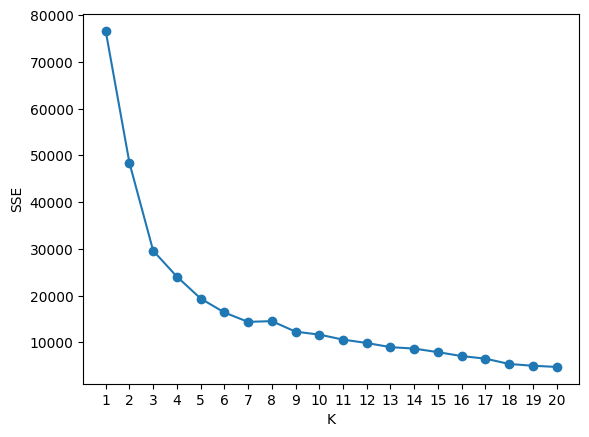

Text(0.5, 0, 'k')

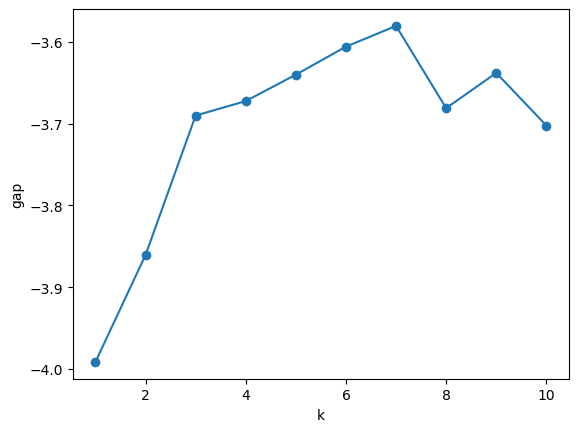

In [6]:
from sklearn.cluster import KMeans

K = np.linspace(1, 20, 20)
X = united_progressive[["x", "y", "end_x", "end_y", "angle"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)
    
plt.scatter(elbow["k"], elbow["sse"])  
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 10
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

## Clustering

After we found the optimal number of clusters we can cluster passes from a game. Then, we plot each cluster on 
a separate plot.



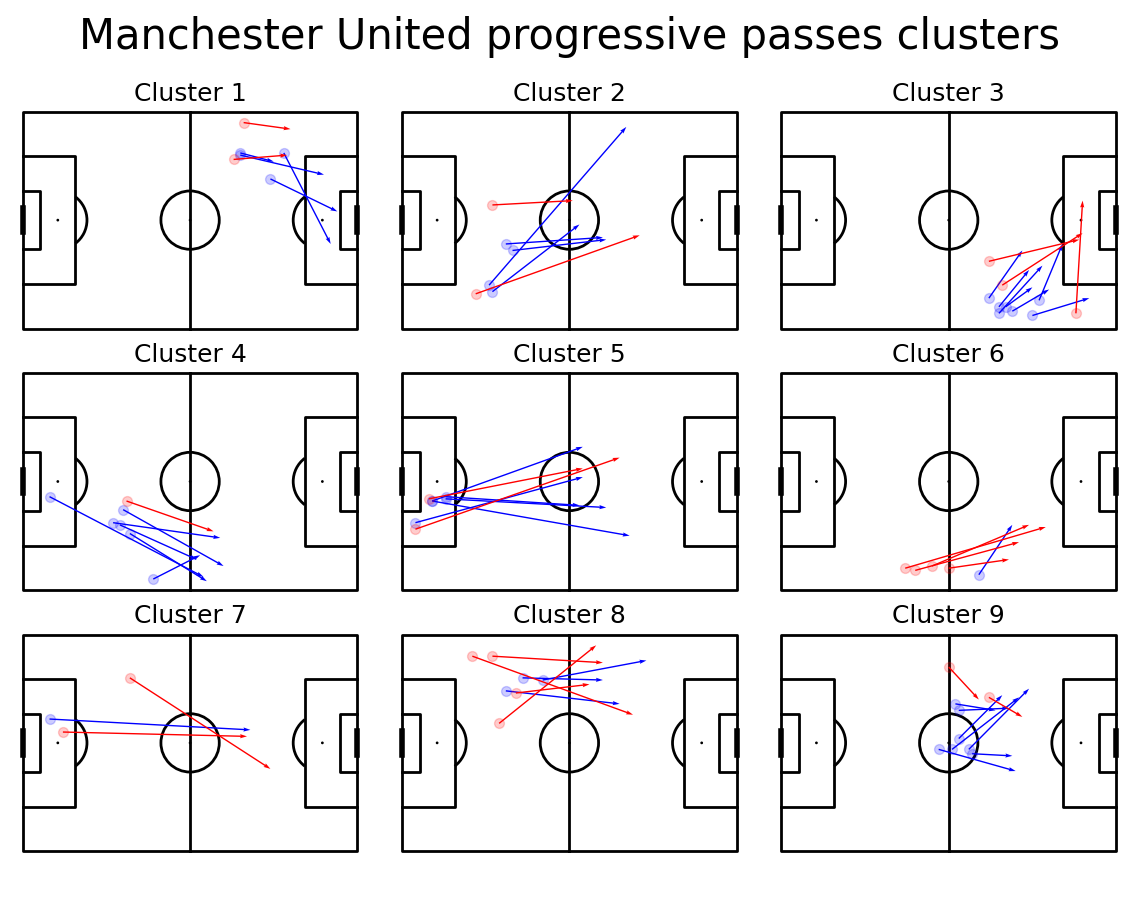

In [7]:
k = 9
cluster = KMeans(n_clusters = int(k), random_state = 2147)
labels = cluster.fit_predict(X)

united_progressive["label"] = labels


pitch = Pitch(line_color='black', pitch_type = "custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(ncols = 3, nrows = 3, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#for each player
for clust, ax in zip(np.linspace(0, k-1, k), axs['pitch'].flat[:k]):
    #put player name over the plot
    ax.text(52.5, 74, "Cluster " + str(int(clust+1)),
            ha='center', va='center', fontsize=18)
    #take only passes by this player
    clustered = united_progressive.loc[united_progressive["label"] == clust]
    #scatter
    correct = clustered.loc[clustered.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    pitch.scatter(correct.x, correct.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(correct.x, correct.y,
            correct.end_x, correct.end_y, color = "blue", ax=ax, width=1)
    incorrect = clustered.loc[clustered.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
    pitch.scatter(incorrect.x, incorrect.y, alpha = 0.2, s = 50, color = "red", ax=ax)
    #plot arrow
    pitch.arrows(incorrect.x, incorrect.y,
            incorrect.end_x, incorrect.end_y, color = "red", ax=ax, width=1)

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, 'Manchester United progressive passes clusters', ha='center', va='center', fontsize=30)
plt.show()